## Install packages

In [ ]:
# @title
import pathlib
import shutil
import tempfile

# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
import scipy.linalg as la
from scipy.stats.mstats import winsorize

# Plot data
from  IPython import display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

# scikit-learn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# tensorflow
import tensorflow as tf

import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.15.0


## Read data

In [ ]:
auto = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2022MLWEEK_MLWITHPYTHON/main/data/Auto.csv')

In [ ]:
# SOURCE: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

auto = auto.copy()

auto['horsepower'] = auto.loc[:, 'horsepower'].replace('?', np.nan)

auto = auto.dropna()

auto['horsepower'] = auto.loc[:, 'horsepower'].astype('int')

auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


## Relationship between `Horsepower` and `MPG`

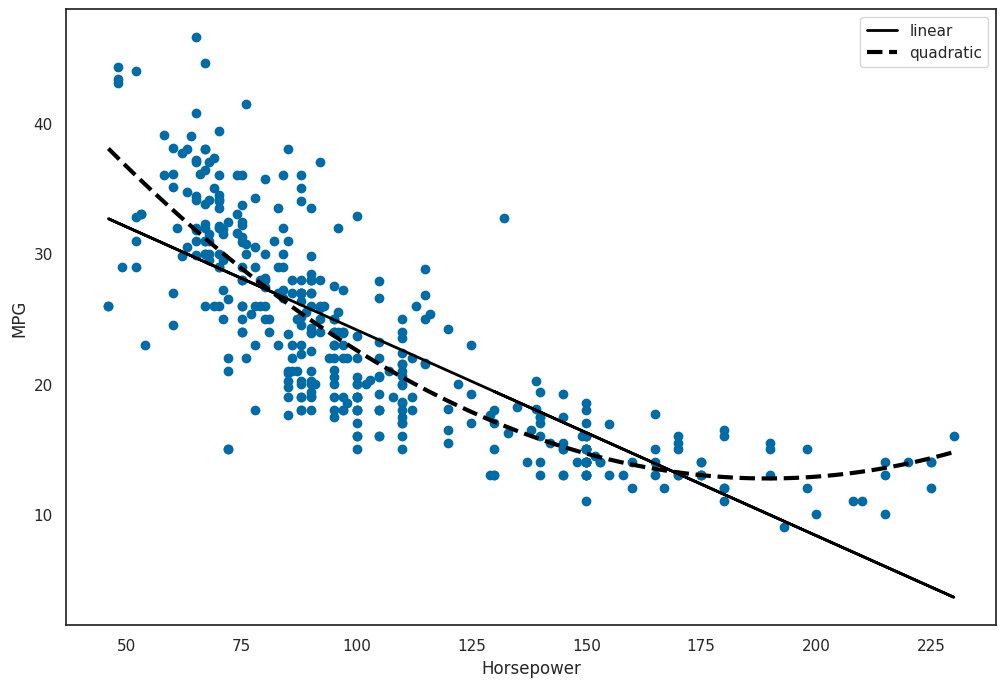

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

m1 = stats.linregress(auto.horsepower, auto.mpg)
m2 = np.poly1d(np.polyfit(auto.horsepower, auto.mpg, 2))
m2line = np.linspace(auto.horsepower.min(), auto.horsepower.max(), 100)

ax.scatter(auto.horsepower, auto.mpg)
plt.plot(auto.horsepower, m1.intercept + m1.slope*auto.horsepower, 'k-', linewidth=2, label='linear')
plt.plot(m2line, m2(m2line), 'k--', linewidth=3, label='quadratic')
ax.set_xlabel('Horsepower')
ax.set_ylabel('MPG')
ax.legend();

## 1. Create train and test datasets

## 1a. Split the `auto` dataset into train and test sets using [`pandas`](https://www.statology.org/pandas-sample-with-replacement/)

In [ ]:
train = auto[['horsepower', 'mpg']].sample(n=196)

test  = auto.loc[~auto.index.isin(train.index), ['horsepower', 'mpg']]

train.shape, test.shape

((196, 2), (196, 2))

## 1b. Split the `auto` dataset into train and test sets using [`scikit-learn`](https://scikit-learn.org/stable/modules/cross_validation.html)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(auto['horsepower'], auto['mpg'], test_size=0.5)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196,), (196,), (196,), (196,))

## 2. Create a [dummy regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) and evaluate its train and test performance

In [ ]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(X_train, y_train)

print(f'Train R^2: {abs(np.round(dummy_regr.score(X_train, y_train),1))}\nTest  R^2: {abs(np.round(dummy_regr.score(X_test, y_test),1))}') # dummy_regr.score returns R^2 for regression

Train R^2: 0.0
Test  R^2: 0.0


## 3. Fit a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and evaluate its test performance with [`cross_val_score`](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics)

In [ ]:
lr = LinearRegression()

scores = cross_val_score(lr, X_train.values.reshape(-1,1), y_train, cv=10)

print(f"R^2: {np.round(scores.mean(),2)} with a standard deviation of {np.round(scores.std(),2)}")

R^2: 0.56 with a standard deviation of 0.1


## 4. Fit a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and evaluate its test performance with [`KFold`](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) cross validation

In [ ]:
lr = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(auto['horsepower'], auto['mpg'])):
    X_train, y_train = auto['horsepower'][auto['horsepower'].index.isin(train)].values.reshape(-1,1), auto['mpg'][auto['mpg'].index.isin(train)]
    X_test,  y_test  = auto['horsepower'][auto['horsepower'].index.isin(test)].values.reshape(-1,1),  auto['mpg'][auto['mpg'].index.isin(test)]
    lr.fit(X_train, y_train)
    score = lr.score(X_test, y_test)
    scores.append(score)
    print('Fold: {:2d}, R^2: {:.3f}'.format(k+1, score))

print('\nCV R^2: {:.3f} std (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, R^2: 0.573
Fold:  2, R^2: 0.604
Fold:  3, R^2: 0.669
Fold:  4, R^2: 0.510
Fold:  5, R^2: 0.625

CV R^2: 0.596 std (+/- 0.053)


## 5. Fit a [linear regression](https://colab.research.google.com/drive/13DNNjirwusTw_hh8eAnMGm8LDGSgaKZx?usp=sharing) with [`Keras`](https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_one_variable) and evaluate its test performance

In [ ]:
# Clear session and set a random seed for consistent behavior.
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# Use Keras Sequential API to build a linear regression model.
linear_model = keras.Sequential()

# create input layer
linear_model.add(tf.keras.Input(shape=(1,),
    name='Input'
))

# create output layer
linear_model.add(keras.layers.Dense(
    activation = None, # linear activation is used
    units=1,           # there is a single output
    use_bias=True      # include a learned bias parameter
))

# Use mean squared error as our loss and the Adam optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
linear_model.compile(loss='mean_squared_error', optimizer=optimizer)

# Return linear_model
linear_model

In [ ]:
history = linear_model.fit(X_train,
                           y_train,
                           batch_size=50,
                           epochs=20,
                           validation_data=(X_test, y_test),
                           verbose=0)
history

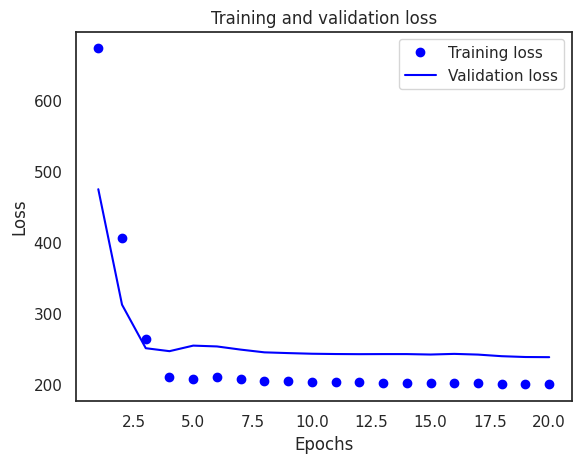

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();